# 1. Data Import


Import the data from the TSV files.

In [1]:
import pandas as pd

# Load train and validation datasets from TSV files
train_df = pd.read_csv("/kaggle/input/telugu-lexicon/te.translit.sampled.train.tsv", sep="\t", header=None)
train_df.columns = ["target", "source", "label"]


val_df = pd.read_csv("/kaggle/input/telugu-lexicon/te.translit.sampled.dev.tsv", sep="\t", header=None)
val_df.columns = ["target", "source", "label"]

# Drop any rows where source or target is missing
train_df = train_df.dropna(subset=["source", "target"])
val_df = val_df.dropna(subset=["source", "target"])

# Ensure source and target are strings
train_df["source"] = train_df["source"].astype(str)
train_df["target"] = train_df["target"].astype(str)
val_df["source"] = val_df["source"].astype(str)
val_df["target"] = val_df["target"].astype(str)

# Create pairs
pairs = list(zip(train_df["source"], train_df["target"]))
val_pairs = list(zip(val_df["source"], val_df["target"]))

In [2]:
import random

# Sample 10,000 examples for faster experimentation. Otherwise, training takes too long

sample_size = 10000
pairs = random.sample(pairs, sample_size)    

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim


# 2. Tokenization and Vocabulary Indexing

In [4]:
# Extract unique characters for both source and target languages

SRC_CHARS = set("".join(s for s, _ in pairs))
TRG_CHARS = set("".join(t for _, t in pairs)) | {"<sos>", "<eos>"}

# Create index mappings for characters

src2idx = {ch: i+1 for i, ch in enumerate(sorted(SRC_CHARS))}  # reserve 0 for padding
src2idx["<pad>"] = 0
trg2idx = {ch: i+1 for i, ch in enumerate(sorted(TRG_CHARS))}
trg2idx["<pad>"] = 0

idx2trg = {i: ch for ch, i in trg2idx.items()}


# 3. Model Definition: Encoder-Decoder

Define the encoder-decoder structure with the added attention mechanism in the decoder.

In [5]:
import torch
import torch.nn as nn

#  RNN Cell Wrapper  #
# Returns the appropriate RNN cell class based on the input string
# Supported cell types: GRU, LSTM, RNN

def get_rnn_cell(cell_type):
    cell_type = cell_type.upper()
    if cell_type == "GRU":
        return nn.GRU
    elif cell_type == "LSTM":
        return nn.LSTM
    elif cell_type == "RNN":
        return nn.RNN
    else:
        raise ValueError("Unsupported RNN cell type. Use 'RNN', 'GRU', or 'LSTM'.")

#  Encoder  #
# Encodes the source sequence into context representations using an RNN

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, cell_type="GRU", dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.rnn = get_rnn_cell(cell_type)(emb_dim, hidden_dim, batch_first=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [src_len, 1, emb_dim]
        outputs, hidden = self.rnn(embedded)  # outputs: [src_len, 1, hidden_dim]
        return outputs, hidden

#  Attention Mechanism  #
# Computes attention weights and context vectors for decoder

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, hidden, encoder_outputs):
        # Handle LSTM or GRU hidden state
        if isinstance(hidden, tuple):  # LSTM case: use hidden state h_n
            hidden = hidden[0]  # use only h_n for attention

        src_len = encoder_outputs.size(0)
        hidden = hidden.repeat(src_len, 1, 1)  # Repeat hidden state for each encoder time step

        # Concatenate encoder outputs and decoder hidden state, apply tanh
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [src_len, batch, hidden_dim]
        energy = energy.squeeze(1)  # [src_len, hidden_dim]
        v = self.v.repeat(src_len, 1)
        scores = torch.sum(v * energy, dim=1)  # Dot-product style scoring
        return torch.softmax(scores, dim=0).unsqueeze(1)  # Normalize scores


#  Attention-based Decoder  #
# Applies attention to focus on encoder outputs when generating tokens

class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, cell_type="GRU", dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.rnn = get_rnn_cell(cell_type)(emb_dim + hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, hidden, encoder_outputs):
        # input_step: [1, 1] - current input token index
        embedded = self.dropout(self.embedding(input_step))  # [1, 1, emb_dim]

        # Compute attention weights and apply to encoder outputs
        attn_weights = self.attention(hidden, encoder_outputs)  # [src_len, 1]
        attn_weights = attn_weights.permute(1, 0)  # [1, src_len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # context: [1, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [1, 1, hidden_dim]

        # Combine embedding and context
        rnn_input = torch.cat((embedded, context), dim=2)  # [1, 1, emb_dim + hidden_dim]
        output, hidden = self.rnn(rnn_input, hidden)  # same shape
        output = output.squeeze(0) # Remove time step dimension
        context = context.squeeze(0)
        pred = self.fc_out(torch.cat((output, context), dim=1))  # Final output prediction
        return pred, hidden



#  Basic Decoder (without attention)  #
# Used as baseline for comparison with attention-based decoder

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, cell_type="GRU", num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.rnn = get_rnn_cell(cell_type)(
            emb_dim, hidden_dim, num_layers, dropout=dropout if num_layers > 1 else 0.0
        )
        self.out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, hidden):
        embedded = self.embedding(input_step)  # [1, 1, emb_dim]
        output, hidden = self.rnn(embedded, hidden)
        output = self.dropout(output.squeeze(0))  # Apply dropout to RNN output
        prediction = self.out(output)             # [1, output_dim]
        return prediction, hidden

#  Attention-Based Seq2Seq Wrapper  #
# Wraps encoder and decoder to define complete sequence-to-sequence architecture

class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, sos_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.sos_idx = sos_idx

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        output_dim = self.decoder.fc_out.out_features
        outputs = torch.zeros(trg_len, 1, output_dim).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        input_step = torch.tensor([[self.sos_idx]], device=self.device)

        # Iterate over each decoding step
        for t in range(trg_len):
            output, hidden = self.decoder(input_step, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1).unsqueeze(0)
            input_step = trg[t].unsqueeze(0) if teacher_force else top1

        return outputs

    def adjust_hidden_for_decoder(self, hidden, target_layers):
        """
        Adjust the encoder's hidden state to match the number of decoder layers.
        Pads if encoder has fewer layers, trims if more.
        Works for GRU/RNN (tensor) and LSTM (tuple).
        """
        if isinstance(hidden, tuple):  # LSTM
            h, c = hidden
            h = self._match_layers(h, target_layers)
            c = self._match_layers(c, target_layers)
            return (h, c)
        else:  # GRU or RNN
            return self._match_layers(hidden, target_layers)

    def _match_layers(self, state, target_layers):
        """
        Pad or trim the hidden state tensor to match target number of layers.
        """
        current_layers = state.size(0)
        if current_layers == target_layers:
            return state
        elif current_layers < target_layers:
            diff = target_layers - current_layers
            pad = torch.zeros(diff, state.size(1), state.size(2), device=state.device)
            return torch.cat([state, pad], dim=0)
        else:  # current_layers > target_layers
            return state[:target_layers]


In [6]:
#use GPU for processing if available

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# Helper function that converts a word into a tensor of indices based on a given vocabulary
# Optionally adds the <eos> token at the end

def tensor_from_word(word, mapping, add_eos=False):
    indices = [mapping[ch] for ch in word]
    if add_eos:
        indices.append(mapping["<eos>"])
    return torch.tensor(indices, dtype=torch.long, device=DEVICE).unsqueeze(1)



#  4. Beam Search Decoding 

Define the beam search function.

In [8]:
# Decodes a sequence using beam search to find the most probable output string

def beam_search(model, src_tensor, beam_size=3, max_len=30):
    model.eval()
    with torch.no_grad():
        # Encode the input sequence
        encoder_outputs, hidden = model.encoder(src_tensor)

        # Trim LSTM hidden states if necessary
        if isinstance(hidden, tuple):
            h, c = hidden
            hidden = (
                h[:model.decoder.rnn.num_layers],
                c[:model.decoder.rnn.num_layers],
            )
        else:
            hidden = hidden[:model.decoder.rnn.num_layers]

        # Initialize beam with sequence starting with <sos> token
        sequences = [([model.sos_idx], 0.0, hidden)]

        for _ in range(max_len):
            all_candidates = []
            for seq, score, h in sequences:
                input_step = torch.tensor([[seq[-1]]], device=model.device)
                output, h_new = model.decoder(input_step, h, encoder_outputs)
                probs = torch.log_softmax(output, dim=1)
                topk = torch.topk(probs, beam_size)

                # Expand each current sequence with top-k new tokens
                for i in range(beam_size):
                    token = topk.indices[0][i].item()
                    token_score = topk.values[0][i].item()
                    new_seq = seq + [token]
                    all_candidates.append((new_seq, score + token_score, h_new))

            # Keep top beam_size sequences with highest scores
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_size]

            # If all sequences have ended with <eos>, stop early
            if all(seq[-1] == trg2idx["<eos>"] for seq, _, _ in sequences):
                break

        # Return best sequence (excluding <sos> and <eos> tokens)
        best_seq = sequences[0][0][1:]  # remove <sos>
        return "".join([idx2trg[i] for i in best_seq if i != trg2idx["<eos>"]])


#  5. Training and Evaluation Utilities 

Define the training function and run the wandb sweep.

In [9]:
#install wandb and login

!pip install -q wandb
import wandb


In [10]:
wandb.login(key='af7d7cf29d8954a13afb06c7a0d0c196c36ac51b')


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
#set all the hyperparameter values to test in the sweep

sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "emb_dim": {"values": [16,32,64,256]},
        "hidden_dim": {"values": [16,32,64,256]},
        "cell_type": {"values": ["RNN","GRU","LSTM"]},
        "enc_layers": {"values": [1]},
        "dec_layers": {"values": [1]},
        "dropout": {"values": [0,0.2, 0.3]},
        "beam_size": {"values": [1, 3, 2]},
        "lr": {"values": [0.001, 0.0005]}
    }
}


In [12]:
# This section includes the model training loop, validation metrics computation,
# and logging to Weights & Biases for hyperparameter tuning and experiment tracking.


def train_model(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config

        run.name = f"emb{config.emb_dim}_hid{config.hidden_dim}_{config.cell_type}_enc{config.enc_layers}_dec{config.dec_layers}_drop{int(config.dropout*100)}_beam{config.beam_size}_lr{config.lr}"

        # Initialize encoder and decoder models with the attention mechanism
        encoder = Encoder(len(src2idx), config.emb_dim, config.hidden_dim, cell_type=config.cell_type, dropout=config.dropout)
        decoder = AttnDecoder(len(trg2idx), config.emb_dim, config.hidden_dim, cell_type=config.cell_type, dropout=config.dropout)

        model = AttnSeq2Seq(encoder, decoder, DEVICE, sos_idx=trg2idx["<sos>"]).to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=trg2idx["<pad>"])
        beam_size = config.get("beam_size", 3)

        for epoch in range(1, 6):
            model.train()
            total_loss = 0
            train_correct = 0
            train_total = 0

            for src_word, trg_word in pairs:
                src_tensor = tensor_from_word(src_word, src2idx)
                trg_tensor = tensor_from_word(trg_word, trg2idx, add_eos=True)

                optimizer.zero_grad()
                output = model(src_tensor, trg_tensor, teacher_forcing_ratio=config.get("teacher_forcing_ratio", 0.5))
                loss = criterion(output.view(-1, output.size(-1)), trg_tensor.view(-1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                pred_tokens = output.argmax(-1).view(-1)
                true_tokens = trg_tensor.view(-1)
                mask = true_tokens != trg2idx["<pad>"]
                correct = (pred_tokens == true_tokens) & mask
                train_correct += correct.sum().item()
                train_total += mask.sum().item()

            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            exact_match_count = 0

            with torch.no_grad():
                for src_word, trg_word in val_pairs:
                    src_tensor = tensor_from_word(src_word, src2idx)
                    trg_tensor = tensor_from_word(trg_word, trg2idx, add_eos=True)

                    output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0.0)
                    loss = criterion(output.view(-1, output.size(-1)), trg_tensor.view(-1))
                    val_loss += loss.item()

                    pred_tokens = output.argmax(-1).view(-1)
                    true_tokens = trg_tensor.view(-1)
                    mask = true_tokens != trg2idx["<pad>"]
                    correct = (pred_tokens == true_tokens) & mask
                    val_correct += correct.sum().item()
                    val_total += mask.sum().item()

                    # Beam search for exact match accuracy
                    pred_str = beam_search(model, src_tensor, beam_size=beam_size)
                    if pred_str == trg_word:
                        exact_match_count += 1

            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            exact_match = exact_match_count / len(val_pairs)

            print(f"Epoch {epoch:2d} | "
                  f"Train Loss: {total_loss / len(pairs):.4f} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss / len(val_pairs):.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Val Exact Match: {exact_match:.4f} | "
                  f"Beam Size: {beam_size}")


            wandb.log({
                "epoch": epoch,
                "train_loss": total_loss / len(pairs),
                "val_loss": val_loss / len(val_pairs),
                "train_accuracy": train_correct / train_total,
                "val_accuracy": val_correct / val_total,
                "val_exact_match": exact_match_count / len(val_pairs),
                "beam_size": beam_size
            })


In [13]:
#run the wandb sweep
'''
sweep_id = wandb.sweep(sweep_config, project="transliteration-with-attn-sweep")
wandb.agent(sweep_id, function=train_model, count=2)
wandb.finish()
'''

'\nsweep_id = wandb.sweep(sweep_config, project="transliteration-with-attn-sweep")\nwandb.agent(sweep_id, function=train_model, count=2)\nwandb.finish()\n'

# 6. Best model Evaluation

Evaluate the best performing model on the test dataset. The following configuration was observed to be the best performing model from the wandb sweep analysis.

In [14]:
# Define the best configuration obtained from hyperparameter tuning

best_config = {
    "emb_dim": 16,
    "hidden_dim": 256,
    "cell_type": "LSTM",
    "enc_layers": 1,
    "dec_layers": 1,
    "dropout": 0,
    "beam_size": 1,
    "lr": 0.0005}


Defining a new train function (with similar structure as the training function before) which returns the best model (with trained weights) as output so that we can test the performance on test data.

In [15]:
def best_train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config

        encoder = Encoder(len(src2idx), config.emb_dim, config.hidden_dim,
                          config.cell_type, config.dropout)
        decoder = AttnDecoder(len(trg2idx), config.emb_dim, config.hidden_dim,
                      config.cell_type, dropout=config.dropout)
        model = AttnSeq2Seq(encoder, decoder, DEVICE, sos_idx=trg2idx["<sos>"]).to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=trg2idx["<pad>"])
        beam_size = config.get("beam_size", 3)

        #train the best model for 10 epochs
        for epoch in range(1, 6):
            model.train()
            total_loss = 0
            train_correct = 0
            train_total = 0

            for src_word, trg_word in pairs:
                src_tensor = tensor_from_word(src_word, src2idx)
                trg_tensor = tensor_from_word(trg_word, trg2idx, add_eos=True)

                optimizer.zero_grad()
                output = model(src_tensor, trg_tensor, teacher_forcing_ratio=config.get("teacher_forcing_ratio", 0.5))
                loss = criterion(output.view(-1, output.size(-1)), trg_tensor.view(-1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                pred_tokens = output.argmax(-1).view(-1)
                true_tokens = trg_tensor.view(-1)
                mask = true_tokens != trg2idx["<pad>"]
                correct = (pred_tokens == true_tokens) & mask
                train_correct += correct.sum().item()
                train_total += mask.sum().item()

            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            exact_match_count = 0

            with torch.no_grad():
                for src_word, trg_word in val_pairs:
                    src_tensor = tensor_from_word(src_word, src2idx)
                    trg_tensor = tensor_from_word(trg_word, trg2idx, add_eos=True)

                    output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0.0)
                    loss = criterion(output.view(-1, output.size(-1)), trg_tensor.view(-1))
                    val_loss += loss.item()

                    pred_tokens = output.argmax(-1).view(-1)
                    true_tokens = trg_tensor.view(-1)
                    mask = true_tokens != trg2idx["<pad>"]
                    correct = (pred_tokens == true_tokens) & mask
                    val_correct += correct.sum().item()
                    val_total += mask.sum().item()

                    # Beam search for exact match accuracy
                    pred_str = beam_search(model, src_tensor, beam_size=beam_size)
                    if pred_str == trg_word:
                        exact_match_count += 1

            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            exact_match = exact_match_count / len(val_pairs)

            print(f"Epoch {epoch:2d} | "
                  f"Train Loss: {total_loss / len(pairs):.4f} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss / len(val_pairs):.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Val Exact Match: {exact_match:.4f} | "
                  f"Beam Size: {beam_size}")

            wandb.log({
                "epoch": epoch,
                "train_loss": total_loss / len(pairs),
                "val_loss": val_loss / len(val_pairs),
                "train_accuracy": train_acc,
                "val_accuracy": val_acc,
                "val_exact_match": exact_match,
                "beam_size": beam_size
            })

        return model


In [16]:
#train the best model

model = best_train_model(config=best_config)


Epoch  1 | Train Loss: 1.4041 | Train Acc: 0.5998 | Val Loss: 0.9859 | Val Acc: 0.7125 | Val Exact Match: 0.2646 | Beam Size: 1
Epoch  2 | Train Loss: 0.6457 | Train Acc: 0.8145 | Val Loss: 0.9137 | Val Acc: 0.7515 | Val Exact Match: 0.3396 | Beam Size: 1
Epoch  3 | Train Loss: 0.4959 | Train Acc: 0.8567 | Val Loss: 0.8089 | Val Acc: 0.7877 | Val Exact Match: 0.4116 | Beam Size: 1
Epoch  4 | Train Loss: 0.4146 | Train Acc: 0.8804 | Val Loss: 0.7862 | Val Acc: 0.7939 | Val Exact Match: 0.4137 | Beam Size: 1
Epoch  5 | Train Loss: 0.3382 | Train Acc: 0.9009 | Val Loss: 0.8109 | Val Acc: 0.7984 | Val Exact Match: 0.4213 | Beam Size: 1


beam_size,▁▁▁▁▁
epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▂▁
val_accuracy,▁▄▇██
val_exact_match,▁▄███
val_loss,█▅▂▁▂
beam_size,1
epoch,5
train_accuracy,0.90086
train_loss,0.33822


In [17]:
#load the test data

test_df = pd.read_csv("/kaggle/input/telugu-lexicon/te.translit.sampled.test.tsv", sep="\t", header=None)
test_df.columns = ["target", "source", "label"]  # adjust if only 2 columns
test_df = test_df.dropna(subset=["source", "target"])
test_df["source"] = test_df["source"].astype(str)
test_df["target"] = test_df["target"].astype(str)
test_pairs = list(zip(test_df["source"], test_df["target"]))


In [18]:
# Evaluate model performance on test set

model.eval()
test_correct = 0
test_total = 0
exact_match_count = 0
beam_size = best_config["beam_size"]

with torch.no_grad():
    for src_word, trg_word in test_pairs:
        src_tensor = tensor_from_word(src_word, src2idx)
        trg_tensor = tensor_from_word(trg_word, trg2idx, add_eos=True)

        output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0.0)

        # Character-level accuracy
        pred_tokens = output.argmax(-1).view(-1)
        true_tokens = trg_tensor.view(-1)
        mask = true_tokens != trg2idx["<pad>"]
        correct = (pred_tokens == true_tokens) & mask
        test_correct += correct.sum().item()
        test_total += mask.sum().item()

        # Word-level exact match via beam search
        pred_str = beam_search(model, src_tensor, beam_size=beam_size)
        if pred_str == trg_word:
            exact_match_count += 1

test_char_acc = test_correct / test_total
test_exact_match = exact_match_count / len(test_pairs)

print(f"Test Char Accuracy: {test_char_acc:.4f}")
print(f"Test Exact Match:  {test_exact_match:.4f}")


Test Char Accuracy: 0.8038
Test Exact Match:  0.4221


Visualizing the predictions of the best model.

In [19]:
# Display random predictions in a table

from tabulate import tabulate

def display_predictions(model, test_pairs, beam_size=3, max_samples=10):
    model.eval()
    table = []

    with torch.no_grad():
        sampled_pairs = random.sample(test_pairs, k=min(max_samples, len(test_pairs)))
        for src_word, trg_word in sampled_pairs:
            src_tensor = tensor_from_word(src_word, src2idx)
            pred_str = beam_search(model, src_tensor, beam_size=beam_size)
            match = "✅" if pred_str == trg_word else "❌"
            table.append([src_word, pred_str, trg_word, match])

    headers = ["Input (Latin)", "Predicted (Telugu)", "Target (Telugu)", "Match"]
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))


In [20]:
display_predictions(model, test_pairs, beam_size=best_config["beam_size"], max_samples=10)


╒═════════════════════╤══════════════════════╤═══════════════════╤═════════╕
│ Input (Latin)       │ Predicted (Telugu)   │ Target (Telugu)   │ Match   │
╞═════════════════════╪══════════════════════╪═══════════════════╪═════════╡
│ navambarulo         │ నవంభరులో                │ నవంబరులో             │ ❌      │
├─────────────────────┼──────────────────────┼───────────────────┼─────────┤
│ jaanapadam          │ జానపడం                 │ జానపదం              │ ❌      │
├─────────────────────┼──────────────────────┼───────────────────┼─────────┤
│ phederation         │ ఫెడర్యాషన్               │ ఫెడరేషన్             │ ❌      │
├─────────────────────┼──────────────────────┼───────────────────┼─────────┤
│ thoolubommalaata    │ తోలుబోముమలత              │ తోలుబొమ్మలాట           │ ❌      │
├─────────────────────┼──────────────────────┼───────────────────┼─────────┤
│ nimishamlo          │ నిమిషంలో                 │ నిమిషంలో              │ ✅      │
├─────────────────────┼──────────────────────┼─

Saving all the prediction on test data to a TSV file in folder predictions_attention.

In [21]:
import csv, os, pandas as pd, torch

#  Run model on the whole test set once 
model.eval()
beam = best_config["beam_size"]
records = []                         # rows for the output file

with torch.no_grad():
    for latin, true in test_pairs:
        pred = beam_search(model,
                           tensor_from_word(latin, src2idx),
                           beam_size=beam)
        records.append({"latin": latin,
                        "true": true,
                        "pred": pred})

#  Save as TSV 
out_df = pd.DataFrame(records)
os.makedirs("predictions_attention", exist_ok=True)          # local folder
out_path = "predictions_attention/test_predictions.tsv"
out_df.to_csv(out_path, sep="\t", index=False)
print(f"Saved {len(out_df)} rows ➜ {out_path}")


Saved 5747 rows ➜ predictions_attention/test_predictions.tsv


# 7. Visualizing attention

Generated a grid of heatmaps to determine which input characters get the most attention while predicting a particular output character.

In [22]:
#Need to import the NotoSansTelugu-Regular.ttf file to display telugu text in the heatmaps

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

font_path = "/kaggle/input/nototsanstelugu/NotoSansTelugu-Regular.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = "Noto Sans Telugu"

In [23]:
def decode_with_attention(model, src_word, src2idx, trg2idx, idx2trg, max_len=30):
    """
    Performs inference using a trained Seq2Seq model with attention,
    returning the predicted target token indices and attention weights.

    Args:
        model: Trained attention-based Seq2Seq model.
        src_word (str): Source word (input string).
        src2idx (dict): Mapping from source characters to indices.
        trg2idx (dict): Mapping from target characters to indices.
        idx2trg (dict): Mapping from target indices to characters.
        max_len (int): Maximum output sequence length.

    Returns:
        output_tokens (List[int]): List of predicted target token indices.
        attention_weights (np.ndarray): Array of shape [output_len, src_len],
                                        representing attention weights at each decoding step.
    """
    model.eval()
    with torch.no_grad():
        # Convert source word to tensor: [src_len, 1]
        src_tensor = tensor_from_word(src_word, src2idx)
        encoder_outputs, hidden = model.encoder(src_tensor)
        input_step = torch.tensor([[trg2idx["<sos>"]]], device=DEVICE)

        output_tokens = [] # Store predicted token indices
        attention_weights = [] # Store attention weights at each decoding step

        for _ in range(max_len):
            # Compute attention weights for the current decoder hidden state
            attn_weights = model.decoder.attention(hidden[0] if isinstance(hidden, tuple) else hidden, encoder_outputs)
            attn_weights = attn_weights.permute(1, 0)  # [1, src_len]
            # Compute context vector via weighted sum of encoder outputs
            context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs.permute(1, 0, 2))  # [1, 1, hidden_dim]
            
            # Embed the current input token
            embedded = model.decoder.embedding(input_step)

            # Concatenate embedded input and context, pass through RNN
            rnn_input = torch.cat((embedded, context), dim=2)

            output, hidden = model.decoder.rnn(rnn_input, hidden)
            output = output.squeeze(0)
            context = context.squeeze(0)

            # Generate prediction logits for the next token
            pred = model.decoder.fc_out(torch.cat((output, context), dim=1))  

            # Get the top predicted token index
            top1 = pred.argmax(1).item()
            output_tokens.append(top1)

            # Store attention weights for visualization
            attention_weights.append(attn_weights.squeeze(0).cpu().numpy())

            # Stop decoding if <eos> is predicted
            if idx2trg[top1] == "<eos>":
                break

            # Use predicted token as next input
            input_step = torch.tensor([[top1]], device=DEVICE)

        # Return predictions and attention matrix
        return output_tokens, np.stack(attention_weights)  


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random

# helper  A · grid of attention maps

import matplotlib.pyplot as plt
import numpy as np
import random

def plot_attention_grid(model, test_pairs, src2idx, trg2idx, idx2src, idx2trg, max_samples=9, max_len=30):

    """
    Plots a 3x3 grid of attention heatmaps for randomly sampled test pairs.
    """
    # --- always sample safely ---
    sampled = random.sample(test_pairs, min(max_samples, len(test_pairs)))

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle("Attention Heatmaps", fontsize=16)

    for ax, (src_word, trg_word) in zip(axes.flat, sampled):
        pred_idx, attn = decode_with_attention(model, src_word,
                                               src2idx, trg2idx, idx2trg,
                                               max_len=max_len)

        src_labels = list(src_word)
        trg_labels = [idx2trg[i] for i in pred_idx]

        im = ax.imshow(attn, cmap="viridis", aspect="auto")
        ax.set_xticks(np.arange(len(src_labels)))
        ax.set_yticks(np.arange(len(trg_labels)))
        ax.set_xticklabels(src_labels, rotation=45, ha="right")
        ax.set_yticklabels(trg_labels)
        ax.set_xlabel("Input")
        ax.set_ylabel("Output")
        ax.set_title(f'"{src_word}" → "{trg_word}"')

    plt.tight_layout()
    plt.show()

# helper  B · single attention map

def plot_attention_map(attn, src_word, pred_tokens, idx2trg):
    src_labels = list(src_word)
    trg_labels = [idx2trg[i] for i in pred_tokens]

    plt.figure(figsize=(8, 6))
    im = plt.imshow(attn, cmap="viridis")
    plt.xticks(np.arange(len(src_labels)), src_labels, rotation=45, ha="right")
    plt.yticks(np.arange(len(trg_labels)), trg_labels)
    plt.xlabel("Input Sequence")
    plt.ylabel("Decoded Output")
    plt.title("Attention Heat-map")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_35/2314050187.py:39: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


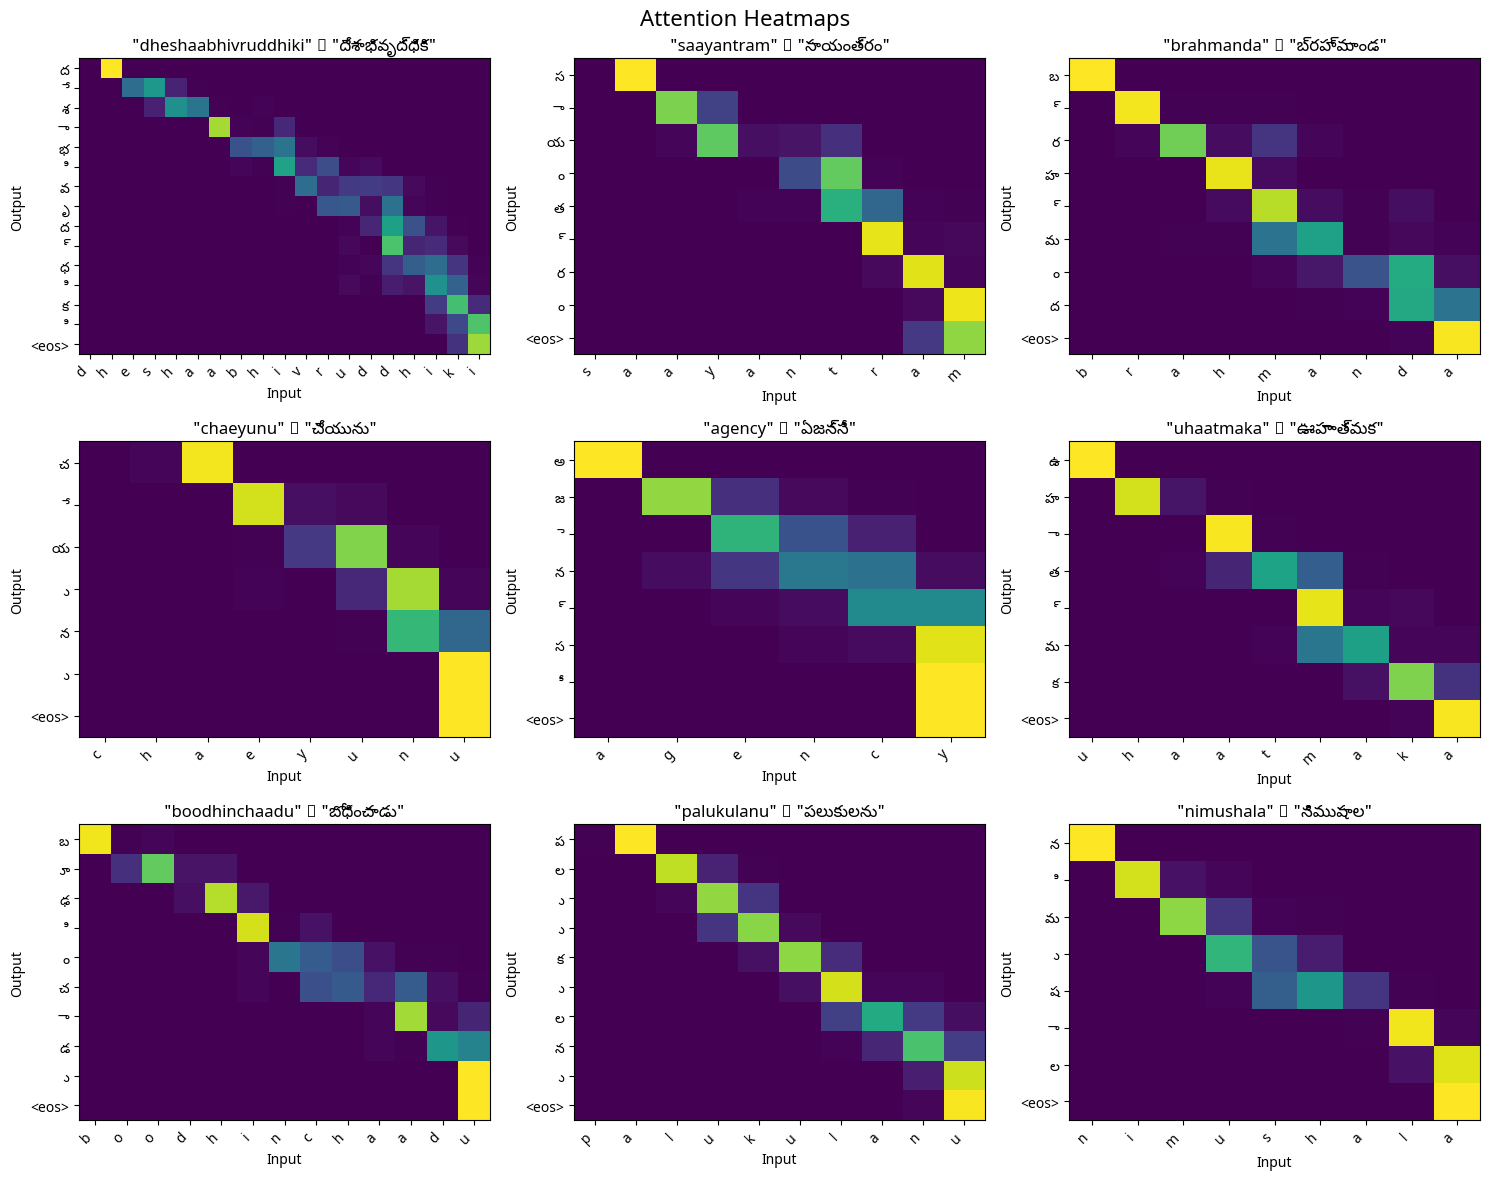

In [25]:
#plotting the grid

idx2src = {i: ch for ch, i in src2idx.items()}
idx2trg = {i: ch for ch, i in trg2idx.items()}


plot_attention_grid(model, test_pairs, src2idx, trg2idx, idx2src, idx2trg, max_samples=9)


In [26]:
pred_tokens, attn_matrix = decode_with_attention(model, src_word, src2idx, trg2idx, idx2trg)


In [27]:
import seaborn as sns

def plot_attention_map(attn, src_word, pred_tokens, idx2trg):
    src_labels = list(src_word)
    trg_labels = [idx2trg[i] for i in pred_tokens]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=src_labels, yticklabels=trg_labels, cmap="viridis", cbar=True)
    plt.xlabel("Input Sequence")
    plt.ylabel("Decoded Output")
    plt.title("Attention Heatmap")
    plt.show()


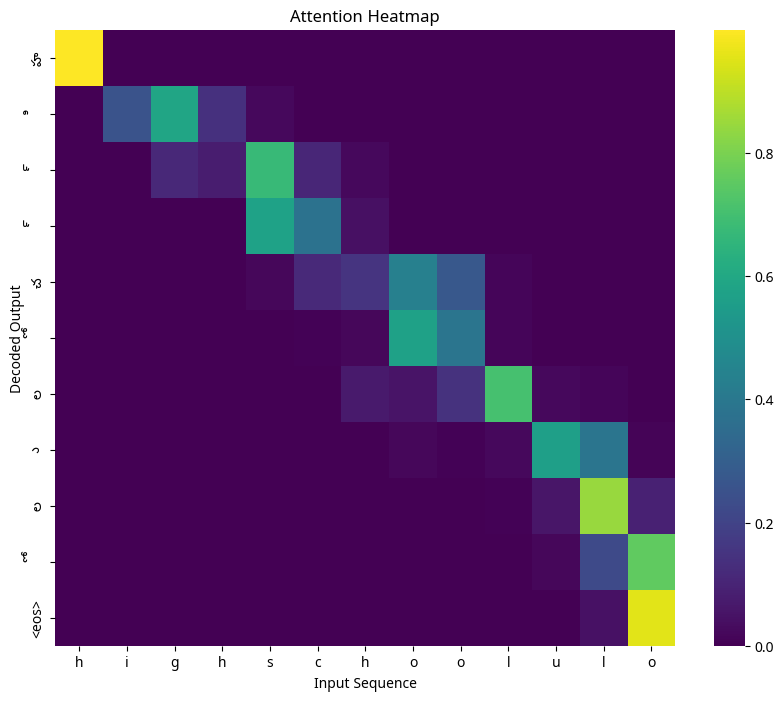

In [28]:
plot_attention_map(attn_matrix, src_word, pred_tokens, idx2trg)


# 8. Connectivity widget

Now we will try to make a widget as described in Question 6 to visualize the attention mechanism applied by our best model.


In [29]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
from ipywidgets import interact, IntSlider, Dropdown, HBox, VBox
from IPython.display import HTML, display
import numpy as np

def attention_blocks_html(src, pred, attn, step):
    """
    Renders input chars in a row of colored blocks for one output‐step.
    
    src  : str, input sequence
    pred : str, predicted output sequence
    attn : np.array shape (len(pred), len(src))
    step : int, which output index to show
    """
    # clamp step
    step = min(max(step, 0), attn.shape[0] - 1)
    weights = attn[step]  # shape = [len(src)]
    
    # Build HTML
    html = "<div style='font-family: monospace;'>"
    html += f"<strong>Decoding step {step} → “{pred[step]}”</strong></div>"
    html += "<table style='border-collapse: collapse;'><tr>"
    for ch, w in zip(src, weights):
        # use red→transparent, alpha = w
        bg = f"rgba(255,0,0,{w:.3f})"
        html += (
            f"<td "
            f"style='border:1px solid #aaa; background:{bg}; "
            f"padding:8px; font-size:20px; text-align:center;'>"
            f"{ch}</td>"
        )
    html += "</tr></table>"
    
    display(HTML(html))



In [31]:
from ipywidgets import Dropdown, IntSlider, HBox, VBox, Output
from IPython.display import display

def interactive_attention_blocks(cache):
    """
    cache : list of (src, pred, attn) tuples
    """
    # 1) Dropdown for selecting the example
    ex_opts = {f"{i}: {s}→{p}": i for i,(s,p,_) in enumerate(cache)}
    ex_dd  = Dropdown(options=ex_opts, description="Example")

    # 2) A slider, dummy-initialized
    slider = IntSlider(description="Step", min=0, max=0, value=0)

    # 3) An output area
    out = Output()

    # Callback #1: when you pick a new example, update slider.max to len(pred)-1
    def _on_example_change(change):
        idx = change['new']
        _, pred, _ = cache[idx]
        slider.max = len(pred) - 1
        slider.value = 0           # reset to first step

    ex_dd.observe(_on_example_change, names='value')

    # Callback #2: whenever example *or* slider changes, redraw
    def _update(_):
        with out:
            out.clear_output(wait=True)
            idx  = ex_dd.value
            step = slider.value
            src, pred, attn = cache[idx]
            # clamp step just in case
            step = max(0, min(step, len(pred)-1))
            attention_blocks_html(src, pred, attn, step)

    ex_dd.observe(_update, names='value')
    slider.observe(_update, names='value')

    # 4) Initialize slider range & draw initial view
    _on_example_change({'new': ex_dd.value})
    _update(None)

    # 5) Put it all together
    controls = HBox([ex_dd, slider])
    widget = VBox([controls, out])
    display(widget)


In [32]:
# 1. Build a small cache
import random
cache = []
for src, trg in random.sample(test_pairs, k=min(9, len(test_pairs))):
    pred_idx, attn = decode_with_attention(model, src, src2idx, trg2idx, idx2trg)
    pred = "".join(idx2trg[i] for i in pred_idx if idx2trg[i] != "<eos>")
    cache.append((src, pred, attn))

# 2. Call the widget
interactive_attention_blocks(cache)


You can select any of the available 9 examples from the dropdown and use the slider to set the decoding step. The visual will show how much attention was paid to each input character to decode the predicted output character. The color gradient represents the attention weight. Brighter red means more attention, lighter red means less attention and white means no attention at all.